# Preprocessing of Data from DaNewsRoom
Preprocessing of the DaNewsRoom datasetfor the Cultural Data Science Project 2022 by @drasbaek and @MinaAlmasi

[DaNewsRoom dataset](https://github.com/alexandrainst/danlp/blob/master/docs/docs/tasks/sentiment_analysis.md)

## Import Packages & Mount Google Drive

In [1]:
# import packages for data import
import gzip 
import pandas as pd 

In [2]:
#progress bar 
!pip -q install tqdm ipywidgets
from tqdm import tqdm
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [3]:
# mount google drive (if run from google colab)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
import matplotlib.pyplot as plt #import for plotting
import matplotlib as mpl #import for plotting high res

## Import Raw Data

In [4]:
# open gzip file (jsonl)
with gzip.open("/content/drive/MyDrive/000 bachelor-project/danewsroom/danewsroom.jsonl.gz") as f:
    data = pd.read_json(f, lines=True)

In [5]:
data

,url,archive,title,date,text,summary,density,coverage,compression,compression_bin,coverage_bin,density_bin,site,domain,text_len,valid
0,http://jyllands-posten.dk/indland/politiretsva...,https://web.archive.org/web/20171105143735/htt...,20-årig idømt halvandet års fængsel: Truede un...,1970-08-22 11:05:05.143735,En 20-årig mand fra Middelfart er blevet idømt...,Manden er bl.a. blevet dømt for tre tilfælde a...,2.764706,0.882353,21.882353,medium,medium,mixed,jyllands-posten.dk,jyllands-posten,1917,True
1,http://www.bt.dk/sex-og-samliv/faa-fingrene-ud...,https://web.archive.org/web/20131005065431/htt...,Få fingrene ud af navlen - ellers går dit parf...,1970-08-21 23:56:45.065431,"Torsdag den 3. oktober 2013, 08:00\n\nI denne ...",Vi danskere er blevet mere og mere egoistiske ...,0.333333,0.333333,2.583333,low,low,abstractive,www.bt.dk,bt,468,True
2,http://www.bt.dk/udland/700-brandfolk-kaemper-...,https://web.archive.org/web/20090816213500/htt...,700 brandfolk kæmper mod skovbrande,1970-08-21 12:46:56.213500,"- Lørdag den 15. august 2009, 05:26\n\nDer er ...",Der er indført undtagelsestilstand i bjergene ...,26.166667,0.966667,5.266667,low,high,extractive,www.bt.dk,bt,864,True
3,http://www.kristeligt-dagblad.dk/familieliv/al...,https://web.archive.org/web/20150702194844/htt...,Forældre skal ikke lære børn at blive perfekte,1970-08-22 05:25:02.194844,Den svenske psykolog Petra Krantz Lindgrens rå...,Den svenske psykolog Petra Krantz Lindgrens rå...,26.000000,1.000000,17.500000,medium,high,extractive,www.kristeligt-dagblad.dk,kristeligt-dagblad,2192,True
4,http://www.bt.dk/politik/politisk-kommentator-...,https://web.archive.org/web/20140506014635/htt...,Politisk kommentator: I dag tager Thorning hul...,1970-08-22 02:35:06.014635,Berlingskes politiske kommentator ser det komm...,Berlingskes politiske kommentator ser det komm...,32.000000,1.000000,18.250000,medium,high,extractive,www.bt.dk,bt,3018,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132729,http://www.dr.dk/sporten/fodbold/landsholdet/o...,https://web.archive.org/web/20171007012107/htt...,OVERBLIK Fra Brentford til Sevilla: Sådan klar...,1970-08-22 11:03:27.012107,Kun to ud af 23 spiller i Danmark.\n\nSådan er...,"Bendtner brillerer, mens Dolberg har svært ved...",0.500000,0.500000,13.857143,low,low,abstractive,www.dr.dk,dr,985,True
1132730,http://nyhederne.tv2.dk/article.php/id-7142275...,https://web.archive.org/web/20130923210617/htt...,TV: Tjener overraskes af stor sum drikkepenge,1970-08-21 23:55:23.210617,Tjenere i den amerikanske restaurationsbranche...,Tjenere i den amerikanske restaurationsbranche...,30.000000,1.000000,5.100000,low,high,extractive,nyhederne.tv2.dk,tv2,813,True
1132731,http://www.bt.dk/kendte/se-linda-ps-stoettesan...,https://web.archive.org/web/20131108010445/htt...,Se Linda P's støttesang til reality-stjernerne,1970-08-21 23:58:28.010445,Komikeren Linda P ønsker at gøre den danske be...,Komikeren Linda P ønsker at gøre den danske be...,26.000000,1.000000,3.423077,low,high,extractive,www.bt.dk,bt,479,True
1132732,http://gaffa.dk/nyhed/93626/kanye-west-kommer-...,https://web.archive.org/web/20171104104753/htt...,Kanye West kommer til Glastonbury Festival,1970-08-22 11:05:04.104753,"Emily Eavis, medarrangør af den engelske Glast...",Så er det officielt! Kanye er det andet hovedn...,1.666667,0.733333,20.600000,medium,low,mixed,gaffa.dk,gaffa,1605,True


## Subsetting and Preprocessing Data

### Reduce dataset to only select media
We use a predefined list of the 5 relevant media to filter the rows of the dataset

In [6]:
# defining relevant news media 
domains = ["ekstrabladet", "bt", "seoghoer", "dr", "tv2"]

# filtering data to keep only relevant news media as defined in list
data = data[data["domain"].isin(domains)]

#reset index
data = data.reset_index(drop=True)

# print new length of dataset
len(data)

504510

### Making Year Column
Since the "date" column in the data is bugged, we cannot identify when the articles are from. However, the year of publication is also available in the URLs of the articles. Therefore, we use a regular expression to extract the year in which the article was published from all the URLs. These years are added as a new column.

In [7]:
import re 

#define function to extract year from the url in "archive"
def extract_year_from_url(url):
    # use a regular expression to extract the year from the URL
    year_match = re.search(r'web/\d{4}', url)
    if year_match:
        # return year as an integer
        return int(year_match.group()[-4:])
    else:
        # if the year cannot be extracted, return None
        return None

# define function which uses extract_year_from_url to create year column for data
def create_year_column(data):
    # apply the extract_year_from_url function to the 'archive' column and store the result in the 'year' column
    data['year'] = data['archive'].apply(extract_year_from_url)

# use function
create_year_column(data)

### Checking the distribution of Year Across Domains
Before selecting our articles to analyze, we use a grouped facetted histogram by domain to see which years the different medias have articles from

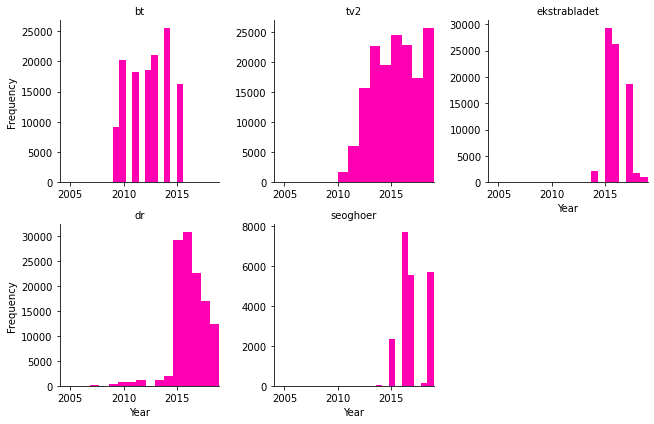

In [11]:
import seaborn as sns

# use seaborn's facetgrid to create a grid of histograms, with one histogram for each domain
g = sns.FacetGrid(data, col="domain", col_wrap=3, sharex=False, sharey=False)

# for each domain, create a histogram with the same bin edges
bins = len(set(data['year']))
g.map(plt.hist, "year", bins=bins, color="#FF00B3")

# adjust layout and show plot
g.set_titles("{col_name}")
g.set(xlim=(min(data['year']), max(data['year'])))
g.set_ylabels("Frequency")
g.set_xlabels("Year")
plt.show()

The plot above shows that the dataset is not equally distributed across years for the different domains. We therefore choose to only select articles from after 2014 as these are the most common in the dataset

### Subsetting 10000 rows from each domain in a fixed time period
Due to having limited computing power, we cannot examine all the XXX remaining articles. Therefore, we select 10,000 observations from each of the five selected domains. These are randomly sampled in order to avoid selection biases.

In [12]:
import random

# Create a new data frame with 10000 rows for each domain, containing randomly selected rows from the original data frame
subset_data = pd.concat([data[(data['domain'] == domain) & (data['year'] > 2014)].sample(10000, random_state=42) for domain in data['domain'].unique()])

# Shuffle the rows of the new data frame
subset_data = subset_data.sample(frac=1, random_state=42).reset_index(drop=True)

### Checking Year Distribution after Subsetting

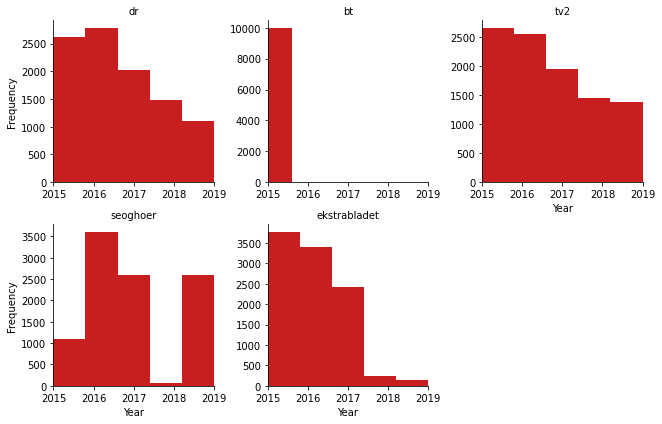

In [13]:
# use seaborn's facetgrid to create a grid of histograms, with one histogram for each domain
g = sns.FacetGrid(subset_data, col="domain", col_wrap=3, sharex=False, sharey=False)

# for each domain, create a histogram with the same bin edges
bins = len(set(subset_data['year']))
g.map(plt.hist, "year", bins=bins, color="#c71f1f")

# adjust layout and show plot
g.set_titles("{col_name}")
g.set(xlim=(min(subset_data['year']), max(subset_data['year'])))
g.set_ylabels("Frequency")
g.set_xlabels("Year")
plt.show()

BT is still of concern, it is kept in the data analysis. 

## Export Data as a CSV
For the sake of accessibility, we choose to export the data as a CSV rather than a zip-compressed JSONL again as CSV is a more common format. This is feasable with our preprocessed data as it has been reduced dramatically in size compared to the original DaNewsRoom

In [14]:
data.to_csv("/content/drive/MyDrive/002 cultural-data-science/data/preprocessed_DaNewsRoom.csv")